In [9]:
import pandas as pd
import torch 
import numpy as np

# Data preprocessing 
import torch 
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   

In [2]:
df = pd.read_csv('data/creditcard.csv')
# print(df.info())
# print(df.isna().sum())
# print(df.describe().T)
# df.corr()['Class'].sort_values(ascending=False)

In [3]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [123]:
X = df.iloc[:, 1:-1].values
y = df['Class'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

#Changer le dataset pour l'adapter au problème de détection de fraude avec auto encoder 
X_fraud = X[y == 1]
X_non_fraud = X[y == 0]


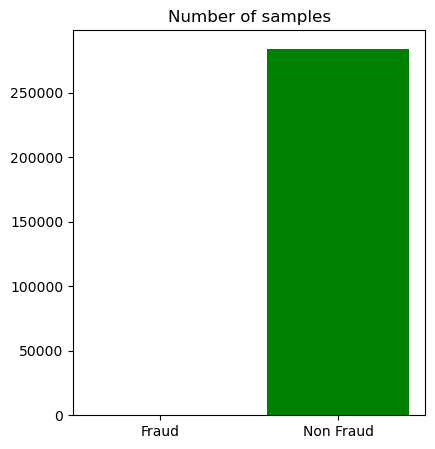

Class
0    284315
1       492
Name: count, dtype: int64

In [124]:
import matplotlib.pyplot as plt
# Visualisation len fraud and non fraud
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['Fraud', 'Non Fraud'], [len(X_fraud), len(X_non_fraud)], color=['red', 'green'])
plt.title('Number of samples')
plt.show()
df['Class'].value_counts()

In [125]:

X_train_non_fraud = X_non_fraud[:int(len(X_non_fraud) * 0.9)]
X_test_fraud = X_fraud
X_test_non_fraud = X_non_fraud[int(len(X_non_fraud) * 0.1):]


# Convert lists to numpy arrays
X_test_fraud = np.array(X_test_fraud, dtype=np.float32)
X_test_non_fraud = np.array(X_test_non_fraud, dtype=np.float32)

# Concaténer les tableaux
X_train = np.array(X_train_non_fraud, dtype=np.float32)
y_train = np.zeros(X_train.shape[0], dtype=np.float32)

X_test = np.concatenate((X_test_fraud, X_test_non_fraud), axis=0)
y_test = np.concatenate((np.ones(X_test_fraud.shape[0]), np.zeros(X_test_non_fraud.shape[0])))



array([ 0.00000000e+00, -1.35980713e+00, -7.27811733e-02,  2.53634674e+00,
        1.37815522e+00, -3.38320770e-01,  4.62387778e-01,  2.39598554e-01,
        9.86979013e-02,  3.63786970e-01,  9.07941720e-02, -5.51599533e-01,
       -6.17800856e-01, -9.91389847e-01, -3.11169354e-01,  1.46817697e+00,
       -4.70400525e-01,  2.07971242e-01,  2.57905802e-02,  4.03992960e-01,
        2.51412098e-01, -1.83067779e-02,  2.77837576e-01, -1.10473910e-01,
        6.69280749e-02,  1.28539358e-01, -1.89114844e-01,  1.33558377e-01,
       -2.10530535e-02,  1.49620000e+02])

In [126]:
class CardFraudDataset(Dataset):
    def __init__(self, data, labels):
        #Convert data to tensor.float32
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    
train_cardFraudDataset = CardFraudDataset(X_train, y_train)
test_cardFraudDataset = CardFraudDataset(X_test, y_test)


In [127]:
train_dataloader = DataLoader(train_cardFraudDataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_cardFraudDataset, batch_size=64, shuffle=False)

In [128]:
class AutoEncoder(nn.Module): 
    def __init__(self, input_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 24),
            nn.ReLU(),
            nn.Linear(24, 12),
            nn.ReLU(),
            nn.Linear(12, 6),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(6, 12),
            nn.ReLU(),
            nn.Linear(12, 24),
            nn.ReLU(),
            nn.Linear(24, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
    

In [135]:
def classifier_fraud(loss):
    """Classify a transaction as fraud or not based on reconstruction loss."""
    threshold = 0.2  # Define a threshold for classification
    return 0 if loss < threshold else 1


In [136]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


torch.manual_seed(42)


# Hyperparameters
latent_dim = 10
input_dim = X_train.shape[1]  # Number of features
lr = 1e-4
epochs = 100

# Define the model, loss, and optimizer
model = AutoEncoder(input_dim=input_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    for data, _ in train_dataloader:
        optimizer.zero_grad()
        inputs = data.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    

    # Evaluation
    model.eval()
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        test_loss = 0.0
        for data, labels in test_dataloader:
            inputs = data.to(device)
            outputs = model(inputs)

            # Reconstruction loss
            reconstruction_loss = nn.MSELoss(reduction='none')(outputs, inputs).sum(dim=1)
            # Classify based on reconstruction loss
            fraud_predictions = [classifier_fraud(loss.item()) for loss in reconstruction_loss]
            true_labels.extend(labels.numpy())
            pred_labels.extend(fraud_predictions)

            # Calculate classification loss (for demonstration)
            classification_targets = torch.tensor(fraud_predictions, device=device, dtype=torch.float32)
            ground_truth = labels
            loss_classification = nn.CrossEntropyLoss()(classification_targets, ground_truth)
            test_loss += loss.item()
        
        # Confusion Matrix
        print(f" Epoch {epoch + 1}/{epochs},Reconstruction Loss: {train_loss / len(train_dataloader):.4f},  Precision: {precision_score(true_labels, pred_labels):.4f}, Recall: {recall_score(true_labels, pred_labels):.4f}, Accuracy: {accuracy_score(true_labels, pred_labels):.4f}, F1 Score: {f1_score(true_labels, pred_labels):.4f}")
        
    # print(f"Epoch {epoch + 1}/{epochs}, Reconstruction Loss: {train_loss / len(train_dataloader):.4f}, Test Loss: {test_loss / len(test_dataloader):.4f}")
    
# Summary
print("Training complete!")


 Epoch 1/100,Reconstruction Loss: 766.5527,  Precision: 0.0019, Recall: 1.0000, Accuracy: 0.0019, F1 Score: 0.0038


KeyboardInterrupt: 

In [97]:
import torch
import torch.nn as nn

# Simuler des données (batch_size=3, num_features=4)
inputs = torch.tensor([[1.0, 2.0, 3.0, 4.0],
                       [2.0, 3.0, 4.0, 5.0],
                       [1.5, 2.5, 3.5, 4.5]])

outputs = torch.tensor([[1.1, 2.1, 2.9, 4.0],
                        [2.0, 3.2, 4.2, 4.9],
                        [1.4, 2.6, 3.6, 4.4]])

# Calcul de la perte
reconstruction_loss = nn.MSELoss(reduction='none')(outputs, inputs).sum(dim=1)
print(reconstruction_loss)


tensor([0.0300, 0.0900, 0.0400])


In [ ]:



confusion_matrix(true_labels, pred_labels)

array([[4, 1],
       [1, 4]])